## FRB130729

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedispersion
import filterbankio
import seaborn as sns

%matplotlib inline

In [2]:
frbFil = 'FRB130729_s41r10b8.fil'

In [3]:
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 1.0})

### Parameters

In [4]:
# standards
timeFactor = 1
freqFactor = 1
dm = 861

start_time = 5.1 # seconds
time_window = 0.2 # seconds

minDM = 0
maxDM = 2000
dmStep = 4

applyGauss = True
fGauss = 8. # bins
tGauss = 8. # bins

####
dm = 851.5
#start_time = 5. # seconds
#time_window = 0.4 # seconds

### Load Filterbank

In [5]:
fil = filterbankio.Filterbank(frbFil)

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

In [6]:
print tInt*1000. * 8
print (fil.freqs[0] - fil.freqs[1])*8

0.512
-3.125


### Dedisperse

In [7]:
ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

### DM Space

In [8]:
#testDMs = np.arange(minDM, maxDM, dmStep)
#dmSpace = np.zeros((testDMs.shape[0], waterfall.shape[0]))
#print dmSpace.shape
#for dmid, dm in enumerate(testDMs):
#    dmSpace[dmid, :] = np.sum(dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap'), axis=1)

#cmap = 'viridis'
#fig = plt.figure(figsize=(4,3)) # (width, height)

#plt.imshow(np.flipud(dmSpace), aspect='auto', extent=(0, tInt*waterfall.shape[0], testDMs[0], testDMs[-1]), cmap=plt.get_cmap(cmap), interpolation='nearest')
#plt.ylabel('DM')
#plt.xlabel('t (s)')
#plt.colorbar(fraction=0.025)

### Decimate

In [9]:
# Time Decimation
# average down by N time samples
if waterfall.shape[0] % timeFactor==0:
    decwaterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor,\
                                        waterfall.shape[1]).sum(axis=1)
    decddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0]/timeFactor, timeFactor,\
                                         ddwaterfall.shape[1]).sum(axis=1)
    tInt *= timeFactor
else:
    print 'WARNING: %i time samples is NOT divisible by %i, zero-padding spectrum to usable size'%(waterfall.shape[0], timeFactor)
    zeros = np.zeros((timeFactor - (waterfall.shape[0] % timeFactor), waterfall.shape[1]))
    decwaterfall = np.concatenate((waterfall, zeros))
    decddwaterfall = np.concatenate((ddwaterfall, zeros))
    decwaterfall = decwaterfall.reshape(decwaterfall.shape[0]/timeFactor, timeFactor,\
                                     decwaterfall.shape[1]).sum(axis=1)
    decddwaterfall = decddwaterfall.reshape(decddwaterfall.shape[0]/timeFactor, timeFactor,\
                                     decddwaterfall.shape[1]).sum(axis=1)
    tInt *= timeFactor

# Frequency Decimation
if decwaterfall.shape[1] % freqFactor==0:
    decwaterfall = decwaterfall.reshape(decwaterfall.shape[0], decwaterfall.shape[1]/freqFactor,\
                                        freqFactor).sum(axis=2)
    decddwaterfall = decddwaterfall.reshape(decddwaterfall.shape[0], decddwaterfall.shape[1]/freqFactor,\
                                            freqFactor).sum(axis=2)
    freqsHz = freqsHz[::freqFactor]
else:
    print 'WARNING: %i frequency channels is NOT divisible by %i, ignoring option'%(decwaterfall.shape[1],\
                                                                                    freqFactor)

### Cut out Region

In [10]:
if start_time is None: startIdx = 0
else: startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = decwaterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > decwaterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = decwaterfall.shape[0]

decwaterfall = decwaterfall[startIdx:endIdx,:]
decddwaterfall = decddwaterfall[startIdx:endIdx,:]

### Blank rows

In [11]:
decddwaterfall[:,200:250] = np.random.normal(decddwaterfall[:,500:600].mean(),\
                                             decddwaterfall[:,500:600].std(), size=decddwaterfall[:,200:250].shape)

### Gaussian Filter

In [12]:
def gaussianFilter(arrShape, tSigma, fSigma):
    # Gaussian filter
    # arrShape: 2-D array shape
    # tSigma: sigma in time (ms)
    # fSigma: sigma in freq (MHz)
    lpos, mpos = np.mgrid[0:arrShape[0],0:arrShape[1]]
    taper = np.exp(-1. * ( (((lpos - (arrShape[0]/2.))**2.) / (2. * tSigma**2.)) + \
                           (((mpos - (arrShape[1]/2.))**2.) / (2. * tSigma**2.)) ))
    return taper

def convolveTaper(gaussImg, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(gaussImg) * np.fft.fft2(img))).real

if applyGauss:
    gaussFilter = gaussianFilter(decddwaterfall.shape, tGauss, fGauss)
    decddwaterfall = convolveTaper(gaussFilter, decddwaterfall)

### Time Series

In [13]:
timeSeries = np.sum(decwaterfall, axis=1)
ddTimeSeries = np.sum(decddwaterfall, axis=1)

### Plots

(3125, 1024)


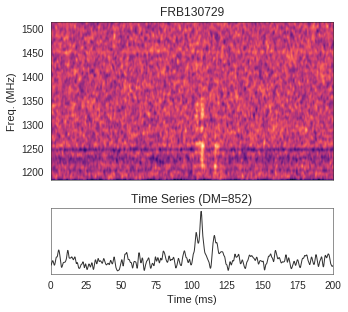

In [14]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

#plt.style.use('dark_background')

#fig = plt.figure(figsize=(12,6)) # (width, height)
fig = plt.figure(figsize=(5,4.5)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
# crop out RFI flagged high freqs
print decddwaterfall.shape
imRaw = plt.imshow(np.flipud(decddwaterfall[:,:850].T), extent=(0, tInt*decddwaterfall.shape[0], fil.freqs[0], fil.freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.title('FRB130729')
plt.ylabel('Freq. (MHz)')
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
#lineColor = 'w'
plt.plot(1000.*tInt*np.arange(decwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*timeSeries.shape[0])
plt.title('Time Series (DM=%0.f)'%dm)
plt.xlabel('Time (ms)')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()

#plt.savefig('FRB130729.png')
plt.savefig('FRB130729.pdf')